In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_curve, auc

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [13]:
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_data.csv")
x = data.loc[:,:'five_year']
y = data['recid_two_year'].values

### CART & EBM

In [5]:
#### CART
depth = [1,2]
impurity = [0.001, 0.003]
split = [2,3,4]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         split=split,
                         impurity=impurity, 
                         seed = 816)

#### GAM
estimators = [40]
depth = [1]
learning_rate = [0.03]
holdout_split = [0.9]
gam_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate = learning_rate,
                       depth = depth,
                       estimators=estimators,
                       holdout_split=holdout_split,
                       seed=816)

model_id, score_thresholds 0 {'rank_abs': [106]}


get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [98]}


get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [100]}


get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [142]}


get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [119]}
get_disparity_predefined_group()


### Lasso Stumps

In [20]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'five_year>=1'], data['recid_two_year'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_test_stumps.csv")

X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'five_year>=1'], train_stumps['recid_two_year'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'five_year>=1'], test_stumps['recid_two_year'].values

Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

In [21]:
cols

Index(['sex', 'p_current_age>=18', 'p_current_age>=19', 'p_current_age>=23',
       'p_current_age>=27', 'p_current_age>=29', 'p_current_age>=30',
       'p_current_age>=31', 'p_current_age>=33', 'p_current_age>=37',
       ...
       'years_since_last_crime>=2.5', 'years_since_last_crime>=3',
       'years_since_last_crime>=3.5', 'years_since_last_crime>=4',
       'years_since_last_crime>=4.5', 'years_since_last_crime>=5',
       'six_month>=1', 'one_year>=1', 'three_year>=1', 'five_year>=1'],
      dtype='object', length=158)

### Nested Cross Validation

In [22]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.1, 0.5]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [205]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [202]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [208]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [183]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [201]}
get_disparity_predefined_group()


##### Best Stump Model
- alpha = 0.1

In [32]:
best_stump_model = stumps.stump_model(X_train_stumps, Y_train_stumps, 
                                      X_test_stumps, Y_test_stumps, 
                                      c=0.1, columns=cols, seed=816)

#### Prediction Table

In [33]:
stumps.stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| sex                               | 5.0            |
| p_current_age>=23                 | -16.7          |
| p_current_age>=29                 | -12.0          |
| p_current_age>=30                 | -27.5          |
| p_current_age>=49                 | -3.1           |
| p_age_first_offense<=22           | 4.7            |
| p_age_first_offense<=30           | 9.2            |
| p_charge>=5                       | 3.7            |
| p_charge>=12                      | 8.2            |
| p_felprop_violarrest>=1           | -21.0          |
| p_felassault_arrest>=1            | -0.7           |
| prior_conviction_M>=2             | 7.3            |
| prior_conviction_M>=3             | 5.3            |
| prior_conviction_M>=4             | 2.9            |
| prior_conviction_M>=5             | 27.4           |
| prior_co

#### Stumps Visualization

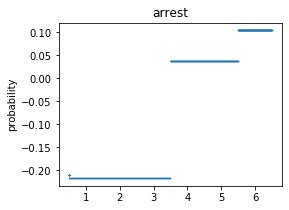

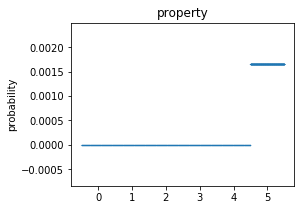

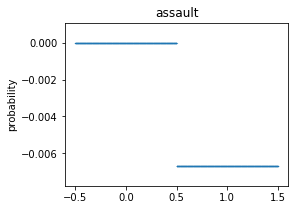

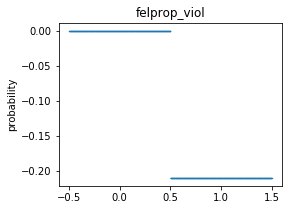

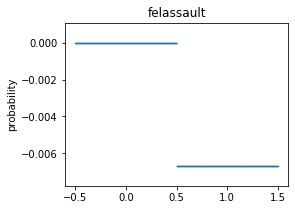

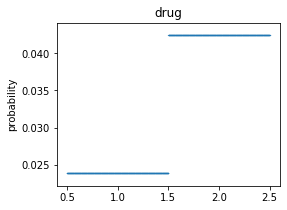

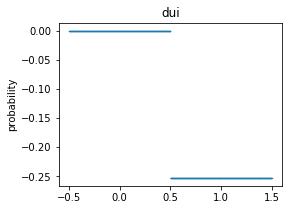

In [34]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'])

### Arnold PSA

In [21]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/broward_arnold.csv")
X_arnold_raw = data['arnold_nca_raw'].values
X_arnold_calc = data['arnold_nca'].values
Y_arnold = data['recid_two_year'].values

In [22]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_fpr, raw_tpr, raw_thresholds = roc_curve(y_test, y_pred_raw)
    calc_fpr, calc_tpr, calc_thresholds = roc_curve(y_test, y_pred_calc)
    raw_auc.append(auc(raw_fpr, raw_tpr))
    calc_auc.append(auc(calc_fpr, calc_tpr))
    i+=1 

### Results

In [23]:
results = [["EBM", ebm_summary['best_validation_auc'], ebm_summary['best_validation_std'], ebm_summary['best_param']], 
           ['Lasso Stumps', round(np.mean(Stump['test_auc']),3), round(np.std(Stump['test_auc']),3)], 
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3), round(np.std(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3), round(np.std(calc_auc), 3)]]

In [24]:
results

[['AdaBoost',
  0.6438730033461224,
  0.018642382119523626,
  {'learning_rate': 0.05, 'n_estimators': 10}],
 ['EBM',
  0.6596007200011168,
  0.02375994427912098,
  {'holdout_split': 0.9,
   'learning_rate': 0.03,
   'max_tree_splits': 1,
   'n_estimators': 40}],
 ['Lasso Stumps', 0.674, 0.007],
 ['Arnold PSA Raw', 0.611, 0.045],
 ['Arnold PSA', 0.605, 0.043]]

In [28]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/model results/Advanced Models/Two Year/"
results = [["", "EBM", "std", "Lasso Stumps", "std", "Arnold PSA Raw", "std", "Arnold PSA", "std"],
           ["General", round(ebm_summary['best_validation_auc'],3), round(ebm_summary['best_validation_std'], 3), round(np.mean(Stump['test_auc']),3), round(np.std(Stump['test_auc']),3), round(np.mean(raw_auc), 3), round(np.std(raw_auc), 3), round(np.mean(calc_auc), 3), round(np.std(calc_auc), 3)]]
with open(path + 'Advanced Models Summary.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)